# Household_power_prediciton
Dataset :  https://www.kaggle.com/sagnikseal/household-power-consumption

In [266]:
# Import the libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,GRU, Input, ConvLSTM2D, Bidirectional,BatchNormalization
from tensorflow.keras import Input
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler,RobustScaler
import math
import json
from IPython.core.pylabtools import figsize
figsize(15, 7) 
df = pd.read_csv(r'E:\Server_mantain\Household_power_prediction\Household_power_consumption\Household_power_consumption.csv', sep=',', 
                 parse_dates={'dt' : ['datetime']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [356]:
df.tail(200)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
dt,,,,,,,,
2010-11-26 17:43:00,1.968,0.0,236.56,8.2,0.0,0.0,17.0,15.799999
2010-11-26 17:44:00,1.972,0.0,236.90,8.2,0.0,0.0,18.0,14.866665
2010-11-26 17:45:00,1.972,0.0,236.83,8.2,0.0,0.0,17.0,15.866665
2010-11-26 17:46:00,1.974,0.0,236.96,8.2,0.0,0.0,17.0,15.900002
2010-11-26 17:47:00,1.986,0.0,237.72,8.2,0.0,0.0,17.0,16.099998
...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0,15.766666
2010-11-26 20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0,15.733334
2010-11-26 21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0,15.633333


In [268]:
def solve_cudnn_error():
    import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized# Memory growth must be set before GPUs have been initialized
            print(e)
solve_cudnn_error()

1 Physical GPUs, 1 Logical GPUs


In [269]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
sub_metering_4           0
dtype: int64

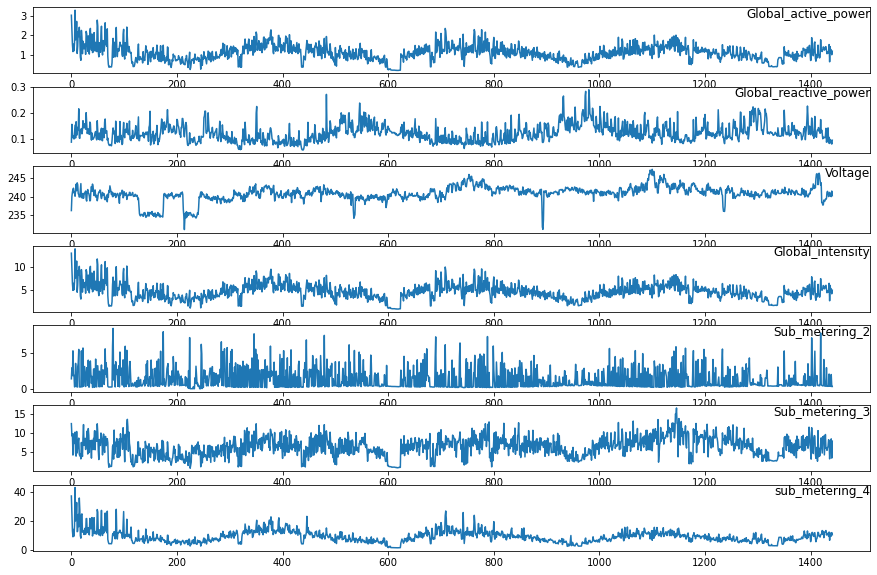

In [270]:
# Below I compare the mean of different featuresresampled over day. 
# specify columns to plot
cols = [0, 1, 2, 3, 5, 6,7]
i = 1
groups=cols
values = df.resample('D').mean().values
# plot each column
plt.figure(figsize=(15, 10))
for group in groups:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.75, loc='right')
	i += 1
plt.show()

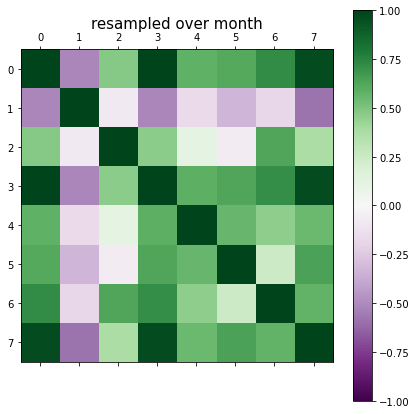

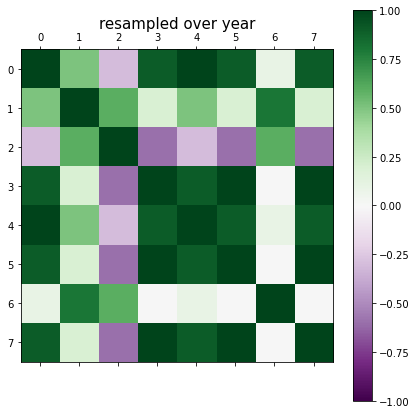

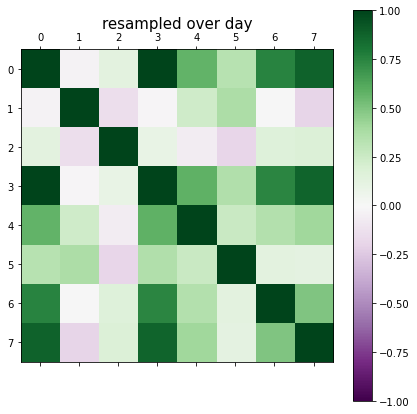

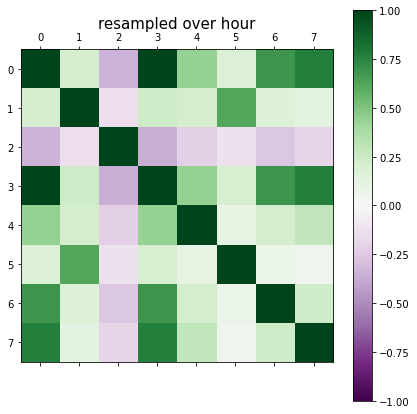

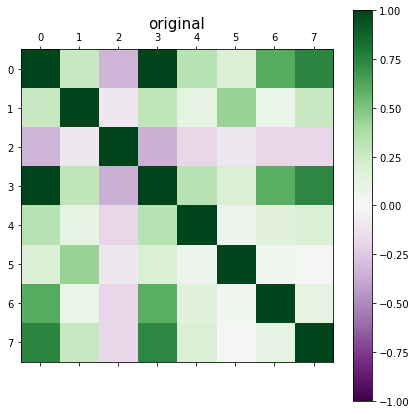

In [271]:
# Correlations of mean of features resampled over months


plt.matshow(df.resample('M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over month', size=15)
plt.colorbar()
plt.margins(0.02)
plt.matshow(df.resample('A').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over year', size=15)
plt.colorbar()
plt.show()
plt.matshow(df.resample('D').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over day', size=15)
plt.colorbar()
plt.show()
plt.matshow(df.resample('h').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over hour', size=15)
plt.colorbar()
plt.show()
plt.matshow(df.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('original', size=15)
plt.colorbar()
plt.show()

In [264]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

# Training

In [298]:
## resampling of data over hour
df_resample = df.resample('h').mean() 
df_resample = df_resample.drop(['Voltage'],axis=1)


## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df_resample.values 


## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = RobustScaler()
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.shape)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

(34588, 14)
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   2.775735   1.709813   2.898026        0.0   0.299145   1.128142   
2   2.296539  -0.378505   2.404605        0.0   9.820513   1.128554   
3   2.108356  -0.305607   2.188158        0.0   1.692308   1.114957   
4   2.001541  -0.447664   2.072368        0.0  -0.512821   1.122373   
5   1.829475  -0.425701   1.900658        0.0   0.128205   1.154512   

   var7(t-1)   var1(t)  
1   6.988386  2.296539  
2   4.615909  2.108356  
3   4.852658  2.001541  
4   4.725286  1.829475  
5   4.076670  1.134776  


In [299]:
# split into train and test sets
values = reframed.values

n_train_time = 365*24*3
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(26280, 1, 7) (26280,) (8308, 1, 7) (8308,)


Epoch 1/10
657/657 [==============================] - 6s 6ms/step - loss: 0.4103 - val_loss: 0.1990
Epoch 2/10
657/657 [==============================] - 3s 5ms/step - loss: 0.2878 - val_loss: 0.1951
Epoch 3/10
657/657 [==============================] - 3s 5ms/step - loss: 0.2865 - val_loss: 0.1939
Epoch 4/10
657/657 [==============================] - 3s 5ms/step - loss: 0.2846 - val_loss: 0.1932
Epoch 5/10
657/657 [==============================] - 3s 5ms/step - loss: 0.2810 - val_loss: 0.1934
Epoch 6/10
657/657 [==============================] - 3s 5ms/step - loss: 0.2791 - val_loss: 0.1932
Epoch 7/10
657/657 [==============================] - 3s 5ms/step - loss: 0.2776 - val_loss: 0.1928
Epoch 8/10
657/657 [==============================] - 3s 5ms/step - loss: 0.2776 - val_loss: 0.1924
Epoch 9/10
657/657 [==============================] - 3s 5ms/step - loss: 0.2776 - val_loss: 0.1924
Epoch 10/10
657/657 [==============================] - 3s 5ms/step - loss: 0.2760 - val_loss: 0.1913

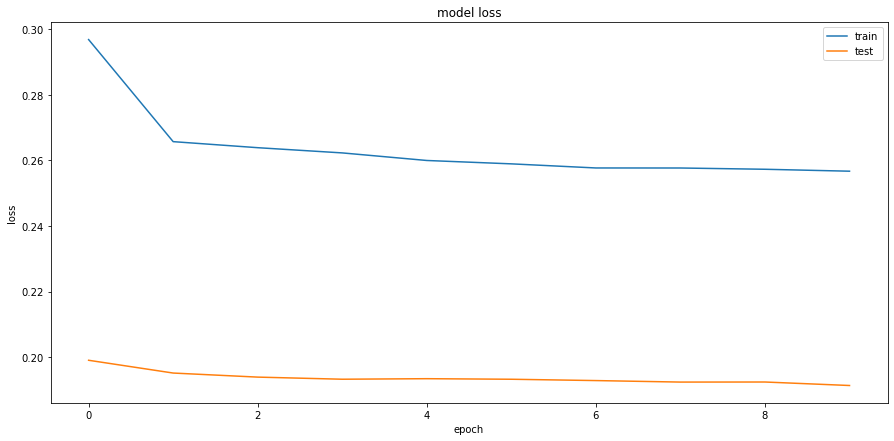

Test RMSE: 0.556


In [300]:
model = Sequential()

model.add(Bidirectional(LSTM(128, return_sequences=False,unroll=False),input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=32, validation_split=0.2, verbose=1, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

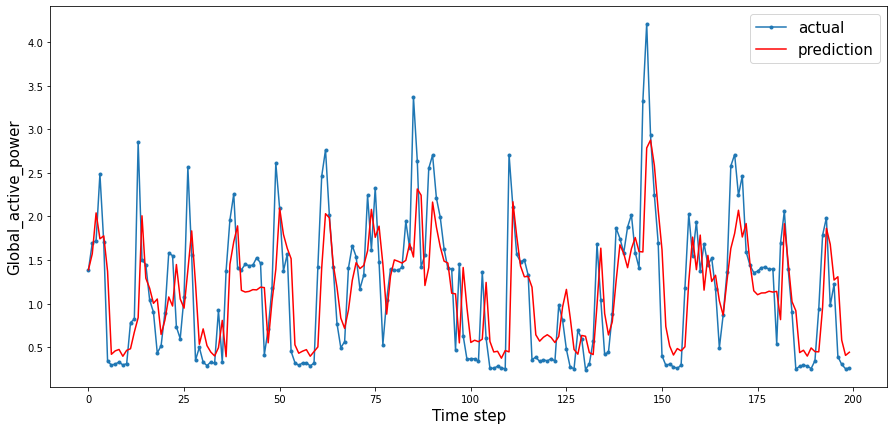

[1.38851587 1.57156602 2.04049102 1.74351196 1.77686928 1.3692955
 0.41917213 0.45822197 0.47448272 0.39641765 0.46442791 0.48277572
 0.67345013 0.83972909 2.00713906 1.29226008 1.17706347 1.00370911
 1.05277325 0.64682634 0.81164621 1.07663676 0.97239398 1.44846457
 1.05359945 0.94822716 1.38296685 1.83396562 1.23115662 0.53386095
 0.71047425 0.5186063  0.44425041 0.39996168 0.49442197 0.80790212
 0.39173009 1.45177179 1.70894219 1.89155356 1.15240531 1.13301008
 1.14020298 1.16046989 1.15763113 1.18901005 1.18379232 0.55085525
 1.02401295 1.39334215 2.0943813  1.7932204  1.63343897 1.51541888
 0.52802913 0.43131481 0.45489248 0.47246575 0.39681572 0.45082834
 0.50344635 1.40770804 2.03089505 1.98497111 1.45406223 1.18585911
 0.83468447 0.71651343 0.92766572 1.26707336 1.4694153  1.40218348
 1.43762963 1.60571516 2.08046352 1.76060978 1.88813995 1.45370361
 0.87987736 1.3162705  1.50167046 1.48510083 1.4654142  1.49615442
 1.68772314 1.53482749 2.31483087 2.24320032 1.20797349 1.41336

In [310]:
## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 

aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()
print(inv_yhat[:200])
print(results.predict())

In [301]:
inv_yhat[:200]

array([1.38851587, 1.57156602, 2.04049102, 1.74351196, 1.77686928,
       1.3692955 , 0.41917213, 0.45822197, 0.47448272, 0.39641765,
       0.46442791, 0.48277572, 0.67345013, 0.83972909, 2.00713906,
       1.29226008, 1.17706347, 1.00370911, 1.05277325, 0.64682634,
       0.81164621, 1.07663676, 0.97239398, 1.44846457, 1.05359945,
       0.94822716, 1.38296685, 1.83396562, 1.23115662, 0.53386095,
       0.71047425, 0.5186063 , 0.44425041, 0.39996168, 0.49442197,
       0.80790212, 0.39173009, 1.45177179, 1.70894219, 1.89155356,
       1.15240531, 1.13301008, 1.14020298, 1.16046989, 1.15763113,
       1.18901005, 1.18379232, 0.55085525, 1.02401295, 1.39334215,
       2.0943813 , 1.7932204 , 1.63343897, 1.51541888, 0.52802913,
       0.43131481, 0.45489248, 0.47246575, 0.39681572, 0.45082834,
       0.50344635, 1.40770804, 2.03089505, 1.98497111, 1.45406223,
       1.18585911, 0.83468447, 0.71651343, 0.92766572, 1.26707336,
       1.4694153 , 1.40218348, 1.43762963, 1.60571516, 2.08046

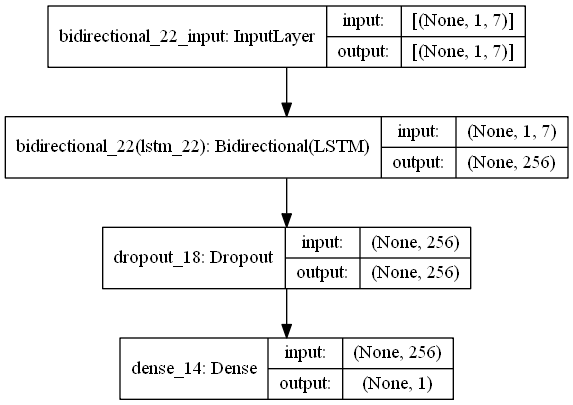

In [129]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [278]:
test_X.shape

(8308, 7)

In [304]:
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [319]:
inv_ARIMA = np.concatenate((results.predict().reshape(-1,1), test_X[:199, -6:]), axis=1)
inv_ARIMA = scaler.inverse_transform(inv_ARIMA)
inv_ARIMA = inv_ARIMA[:,0]

In [463]:
from statsmodels.tsa.arima_model import ARIMA
import warnings


model = ARIMA(inv_y, order=(1, 1, 2))
results = model.fit()
print(results.summary())


C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\user\anaconda3\envs\rtx3070\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsm

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 8307
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -7033.700
Method:                       css-mle   S.D. of innovations              0.564
Date:                Sat, 24 Apr 2021   AIC                          14077.401
Time:                        17:38:26   BIC                          14112.525
Sample:                             1   HQIC                         14089.401
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.395e-05   8.73e-05     -0.160      0.873      -0.000       0.000
ar.L1.D.y      0.5830      0.013     43.903      0.000       0.557       0.609
ma.L1.D.y     -0.8623      0.016    -54.716      0.0

In [465]:
ARIMA_pred = results.predict(exog=inv_y,typ='levels')
Mean_value = (ARIMA_pred+inv_yhat[1:])/2
Add_value = (ARIMA_pred+inv_yhat[1:])

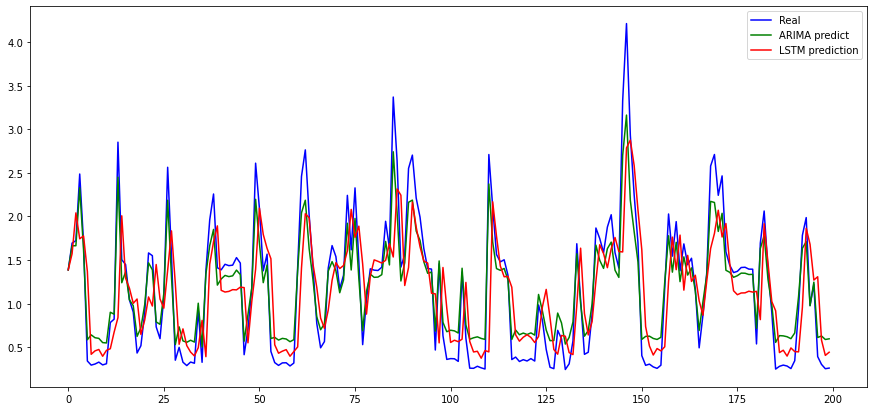

In [466]:
#results.plot_predict(exog=inv_y[:200])
plt.plot(inv_y[:200],color='blue',label='Real')
plt.plot(ARIMA_pred[:200],color='green',label='ARIMA predict')
plt.plot(inv_yhat[:200],color='red',label="LSTM prediction")
#plt.plot(Mean_value[:200],label='Mean')
plt.legend()


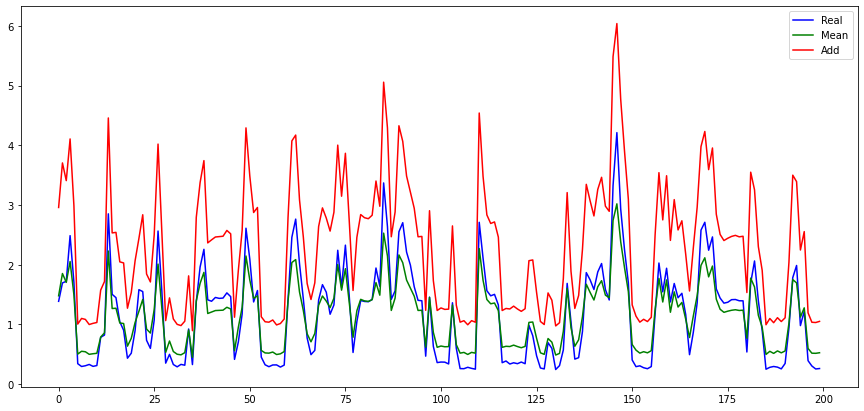

In [473]:
plt.plot(inv_y[:200],color='blue',label='Real')
plt.plot(Mean_value[:200],color='green',label='Mean')
plt.plot(Add_value[:200],color='red',label='Add')
plt.legend()

In [488]:
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import mean_absolute_error
from  datetime import datetime

def fit_score(real,pred,name):
    MAEScore = mean_absolute_error(real,pred)
    RMSEScore = math.sqrt(mean_squared_error(real,pred))
    print('%s Test Score: %.2f MAE' % (name,MAEScore))
    print('%s Test Score: %.2f RMSE' % (name,RMSEScore))
    print('\n')
    
    return MAEScore,RMSEScore
    
    
ARIMA_MAEloss,ARIMA_RMSEloss = fit_score(real=inv_y[1:],pred=ARIMA_pred,name='ARIMA')
LSTM_MAEloss,LSTM_RMSEloss = fit_score(real=inv_y,pred=inv_yhat,name='LSTM')
fit_score(real=inv_y[1:],pred=Mean_value,name='Simple Hybrid model average')
fit_score(real=inv_y[1:],pred=Add_value,name='Simple Hybrid model add')

ARIMA Test Score: 0.41 MAE
ARIMA Test Score: 0.56 RMSE


LSTM Test Score: 0.39 MAE
LSTM Test Score: 0.56 RMSE


Simple Hybrid model average Test Score: 0.39 MAE
Simple Hybrid model average Test Score: 0.55 RMSE


Simple Hybrid model add Test Score: 1.09 MAE
Simple Hybrid model add Test Score: 1.29 RMSE




(1.0867318674711994, 1.2874291095895005)

In [479]:
ARIMA_Loss = (ARIMA_MAEloss+ARIMA_RMSEloss)/2
LSTM_Loss = (LSTM_MAEloss+LSTM_RMSEloss)/2

In [480]:
LSTM_weight = (1-(LSTM_Loss/ARIMA_Loss+LSTM_Loss))*2
ARIMA_weight = 2-LSTM_weight

In [481]:
Hybrid_pred = (LSTM_weight*LSTM_Loss+ARIMA_weight*ARIMA_pred)/2

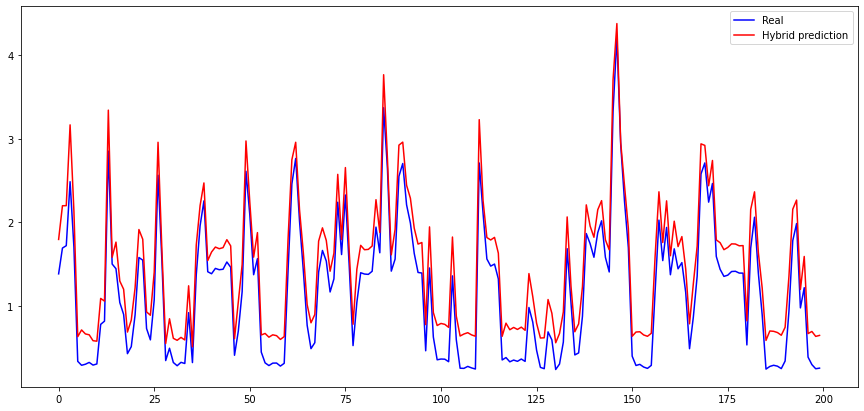

Hybrid model Test Score: 0.51 MAE
Hybrid model Test Score: 0.68 RMSE




(0.510781323651549, 0.6752828294069924)

In [486]:
plt.plot(inv_y[:200],color='blue',label='Real')
plt.plot(Hybrid_pred[:200],color='red',label='Hybrid prediction')
plt.legend()
plt.show()

fit_score(real=inv_y[1:],pred=Hybrid_pred,name='Hybrid model')